In [1]:
!pip -q install pandas numpy matplotlib scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance


In [3]:
import os, zipfile, urllib.request

zip_path = "household_power_consumption.zip"
txt_path = "household_power_consumption.txt"

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"

if not os.path.exists(txt_path):
    print("Downloading...")
    urllib.request.urlretrieve(url, zip_path)

    print("Unzipping...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(".")
    print("Done! File saved as:", txt_path)
else:
    print("Already have:", txt_path)


Already have: household_power_consumption.txt


In [4]:
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=";",
    low_memory=False,
    na_values=["?", "nan"]
)

df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True, errors="coerce")
df = df.drop(columns=["Date", "Time"]).dropna(subset=["datetime"])
df = df.set_index("datetime").sort_index()

df.head(), df.shape


(                     Global_active_power  Global_reactive_power  Voltage  \
 datetime                                                                   
 2006-12-16 17:24:00                4.216                  0.418   234.84   
 2006-12-16 17:25:00                5.360                  0.436   233.63   
 2006-12-16 17:26:00                5.374                  0.498   233.29   
 2006-12-16 17:27:00                5.388                  0.502   233.74   
 2006-12-16 17:28:00                3.666                  0.528   235.68   
 
                      Global_intensity  Sub_metering_1  Sub_metering_2  \
 datetime                                                                
 2006-12-16 17:24:00              18.4             0.0             1.0   
 2006-12-16 17:25:00              23.0             0.0             1.0   
 2006-12-16 17:26:00              23.0             0.0             2.0   
 2006-12-16 17:27:00              23.0             0.0             1.0   
 2006-12-16 17:

In [5]:
df = df.loc[df.index >= (df.index.max() - pd.Timedelta(days=365))].copy()
df.shape


(525601, 7)

In [6]:
# Raw hourly means (will contain NaNs where data is missing)
hourly_raw = df["Global_active_power"].resample("1h").mean()

# Create a complete hourly timeline
full_idx = pd.date_range(hourly_raw.index.min(), hourly_raw.index.max(), freq="h")
hourly_full = hourly_raw.reindex(full_idx)

# Interpolate ONLY small gaps (<=3 hours). Big gaps stay NaN.
hourly = hourly_full.interpolate(limit=3, limit_direction="both")

print("Missing hours after limited interpolation:", hourly.isna().sum())
hourly.head()

Missing hours after limited interpolation: 267


2009-11-26 21:00:00    1.767276
2009-11-26 22:00:00    0.648433
2009-11-26 23:00:00    1.088200
2009-11-27 00:00:00    0.348900
2009-11-27 01:00:00    0.300067
Freq: h, Name: Global_active_power, dtype: float64

In [7]:
data = pd.DataFrame({"y": hourly})

data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek
data["month"] = data.index.month
data["is_weekend"] = (data["dayofweek"] >= 5).astype(int)

data["lag_1"] = data["y"].shift(1)
data["lag_24"] = data["y"].shift(24)
data["lag_168"] = data["y"].shift(168)

data["roll_mean_24"] = data["y"].rolling(24).mean()
data["roll_std_24"]  = data["y"].rolling(24).std()
data["roll_mean_168"] = data["y"].rolling(168).mean()

data["target"] = data["y"].shift(-1)

# Now drop rows with ANY missing (this automatically removes big-gap areas safely)
data = data.dropna()

data.head(), data.shape

(                            y  hour  dayofweek  month  is_weekend     lag_1  \
 2009-12-03 21:00:00  1.599000    21          3     12           0  2.334267   
 2009-12-03 22:00:00  1.580233    22          3     12           0  1.599000   
 2009-12-03 23:00:00  0.545467    23          3     12           0  1.580233   
 2009-12-04 00:00:00  0.379000     0          4     12           0  0.545467   
 2009-12-04 01:00:00  0.408367     1          4     12           0  0.379000   
 
                        lag_24   lag_168  roll_mean_24  roll_std_24  \
 2009-12-03 21:00:00  2.283867  1.767276      1.046874     0.714757   
 2009-12-03 22:00:00  1.832533  0.648433      1.036361     0.704481   
 2009-12-03 23:00:00  0.756667  1.088200      1.027561     0.709428   
 2009-12-04 00:00:00  0.590833  0.348900      1.018735     0.716382   
 2009-12-04 01:00:00  0.404700  0.300067      1.018887     0.716246   
 
                      roll_mean_168    target  
 2009-12-03 21:00:00       1.209674  1.580

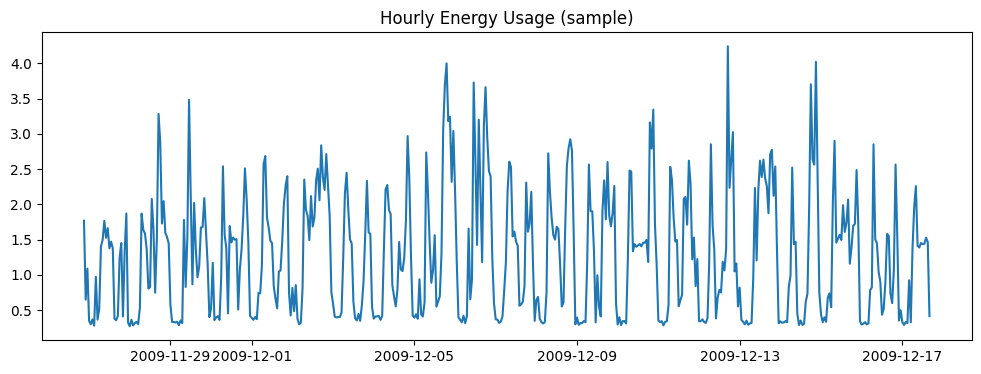

In [8]:
plt.figure(figsize=(12,4))
plt.plot(hourly.index[:500], hourly.values[:500])
plt.title("Hourly Energy Usage (sample)")
plt.show()


In [9]:
data = pd.DataFrame({"y": hourly})

# Time features
data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek
data["month"] = data.index.month
data["is_weekend"] = (data["dayofweek"] >= 5).astype(int)

# Lag features (previous usage)
data["lag_1"] = data["y"].shift(1)       # last hour
data["lag_24"] = data["y"].shift(24)     # same hour yesterday
data["lag_168"] = data["y"].shift(168)   # same hour last week

# Rolling features
data["roll_mean_24"] = data["y"].rolling(24).mean()
data["roll_std_24"] = data["y"].rolling(24).std()
data["roll_mean_168"] = data["y"].rolling(168).mean()

# Target = next hour
data["target"] = data["y"].shift(-1)

data = data.dropna()
data.head()


,y,hour,dayofweek,month,is_weekend,lag_1,lag_24,lag_168,roll_mean_24,roll_std_24,roll_mean_168,target
2009-12-03 21:00:00,1.599000,21,3,12,0,2.334267,2.283867,1.767276,1.046874,0.714757,1.209674,1.580233
2009-12-03 22:00:00,1.580233,22,3,12,0,1.599000,1.832533,0.648433,1.036361,0.704481,1.215221,0.545467
2009-12-03 23:00:00,0.545467,23,3,12,0,1.580233,0.756667,1.088200,1.027561,0.709428,1.211990,0.379000
2009-12-04 00:00:00,0.379000,0,4,12,0,0.545467,0.590833,0.348900,1.018735,0.716382,1.212169,0.408367
2009-12-04 01:00:00,0.408367,1,4,12,0,0.379000,0.404700,0.300067,1.018887,0.716246,1.212814,0.412533


In [10]:
X = data.drop(columns=["y", "target"])
y = data["target"]

split_idx = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape


((6119, 10), (1530, 10))

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_base = X_test["lag_24"]

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))   # <-- manual RMSE

print("Baseline MAE:", round(mae_base, 4))
print("Baseline RMSE:", round(rmse_base, 4))


Baseline MAE: 0.6868
Baseline RMSE: 0.96


In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression MAE:", round(mae_lr, 4))
print("Linear Regression RMSE:", round(rmse_lr, 4))


Linear Regression MAE: 0.5605
Linear Regression RMSE: 0.7296


In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = HistGradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print("GBR MAE:", round(mae_gbr, 4))
print("GBR RMSE:", round(rmse_gbr, 4))


GBR MAE: 0.4528
GBR RMSE: 0.6217


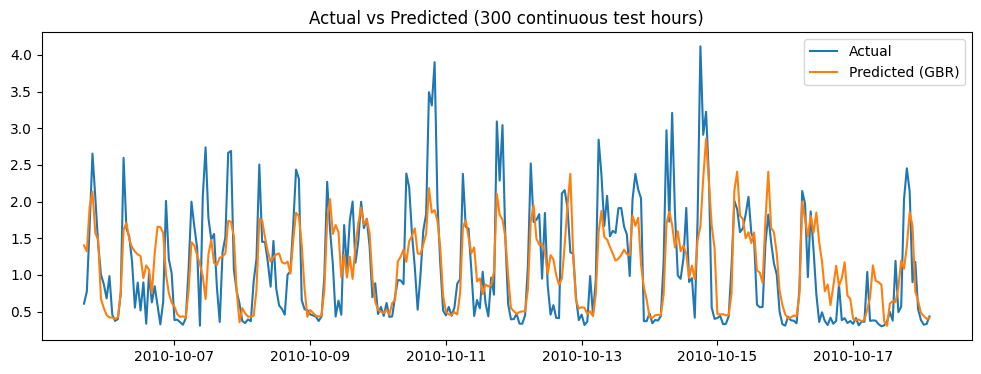

In [14]:
pred_gbr = pd.Series(y_pred_gbr, index=y_test.index)

idx = y_test.index.to_series()
group = (idx.diff() != pd.Timedelta(hours=1)).cumsum()

# pick a segment with at least 300 continuous hours
sizes = group.value_counts().sort_index()
good_group = sizes[sizes >= 300].index[0]

y_block = y_test[group == good_group].iloc[:300]
p_block = pred_gbr[group == good_group].iloc[:300]

plt.figure(figsize=(12,4))
plt.plot(y_block.index, y_block.values, label="Actual")
plt.plot(p_block.index, p_block.values, label="Predicted (GBR)")
plt.title("Actual vs Predicted (300 continuous test hours)")
plt.legend()
plt.show()


In [15]:
gaps = y_test.index.to_series().diff() > pd.Timedelta(hours=1)
print("Number of gaps in y_test:", gaps.sum())

gap_points = y_test.index[gaps]      # this is a DatetimeIndex
print("First few gap points:\n", gap_points[:5])

Number of gaps in y_test: 1
First few gap points:
 DatetimeIndex(['2010-10-05 16:00:00'], dtype='datetime64[us]', freq=None)


In [16]:
from sklearn.inspection import permutation_importance

imp = permutation_importance(gbr, X_test, y_test, n_repeats=5, random_state=42)
feat_imp = pd.Series(imp.importances_mean, index=X_test.columns).sort_values(ascending=False)

feat_imp.head(10)


hour             0.471476
lag_1            0.149437
roll_std_24      0.053381
roll_mean_24     0.030092
dayofweek        0.028890
roll_mean_168    0.015929
lag_24           0.009706
month            0.005737
lag_168          0.001317
is_weekend       0.000000
dtype: float64

In [17]:
import sklearn
sklearn.__version__


'1.8.0'

In [18]:
results = pd.DataFrame({
    "MAE": [mae_base, mae_lr, mae_gbr],
    "RMSE": [rmse_base, rmse_lr, rmse_gbr]
}, index=["Baseline (lag_24)", "Linear Regression", "Gradient Boosting (GBR)"])

results


,MAE,RMSE
Baseline (lag_24),0.686822,0.960021
Linear Regression,0.560517,0.729611
Gradient Boosting (GBR),0.452822,0.621671


In [19]:
import pandas as pd
import numpy as np

# We'll build forecasts starting from the last timestamp in the hourly series you created
y_hist = hourly.copy()
t = y_hist.index.max()

future_preds = []

for _ in range(24):
    # Features at time t predict the next hour (t+1)
    feats = {
        "hour": t.hour,
        "dayofweek": t.dayofweek,
        "month": t.month,
        "is_weekend": int(t.dayofweek >= 5),

        "lag_1": float(y_hist.loc[t]),
        "lag_24": float(y_hist.loc[t - pd.Timedelta(hours=24)]),
        "lag_168": float(y_hist.loc[t - pd.Timedelta(hours=168)]),

        "roll_mean_24": float(y_hist.loc[:t].tail(24).mean()),
        "roll_std_24": float(y_hist.loc[:t].tail(24).std()),
        "roll_mean_168": float(y_hist.loc[:t].tail(168).mean()),
    }

    X_next = pd.DataFrame([feats])
    # Ensure column order matches training
    X_next = X_next[X_train.columns]

    y_next = gbr.predict(X_next)[0]

    next_t = t + pd.Timedelta(hours=1)
    future_preds.append((next_t, y_next))

    # Append prediction into history so lags/rolling work for the next step
    y_hist.loc[next_t] = y_next
    t = next_t

forecast_24h = pd.Series(
    data=[v for _, v in future_preds],
    index=[ts for ts, _ in future_preds],
    name="Forecast_24h"
)

forecast_24h.head()


2010-11-26 22:00:00    1.482860
2010-11-26 23:00:00    0.740884
2010-11-27 00:00:00    0.644870
2010-11-27 01:00:00    0.647679
2010-11-27 02:00:00    0.647679
Name: Forecast_24h, dtype: float64

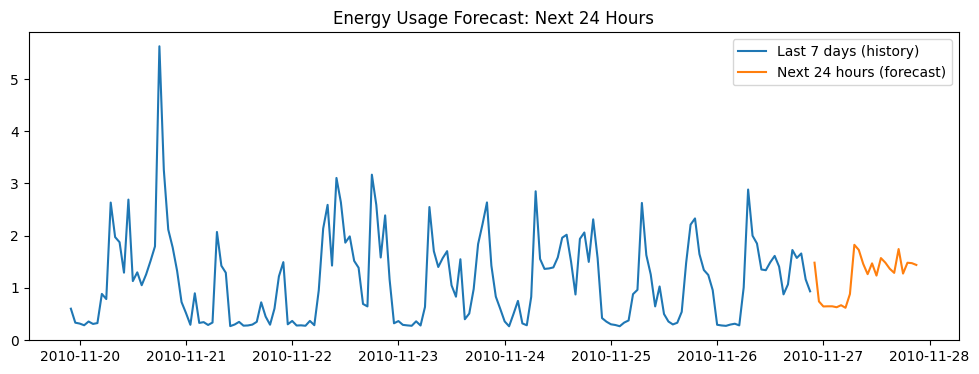

In [20]:
plt.figure(figsize=(12,4))
plt.plot(hourly.tail(24*7), label="Last 7 days (history)")
plt.plot(forecast_24h, label="Next 24 hours (forecast)")
plt.title("Energy Usage Forecast: Next 24 Hours")
plt.legend()
plt.show()


In [21]:
top_peaks = forecast_24h.sort_values(ascending=False).head(3)
low_hours = forecast_24h.sort_values(ascending=True).head(3)

print("Top 3 predicted peak hours (highest usage):")
print(top_peaks)

print("\nTop 3 predicted low-usage hours (best for shifting heavy tasks):")
print(low_hours)


Top 3 predicted peak hours (highest usage):
2010-11-27 07:00:00    1.825224
2010-11-27 17:00:00    1.744593
2010-11-27 08:00:00    1.727703
Name: Forecast_24h, dtype: float64

Top 3 predicted low-usage hours (best for shifting heavy tasks):
2010-11-27 05:00:00    0.619398
2010-11-27 03:00:00    0.630038
2010-11-27 00:00:00    0.644870
Name: Forecast_24h, dtype: float64
